# The search for allopatric speciation in the gut microbial communities of Tanganyikan cichlids

## An adventure in fish poo.

*Russell Neches*

### Import OTU table, sample metadata and host tree

We use python's biom module to extract the OTU counts from the .biom file QIIME gave us. In principle, we could use the biom object to do various slicing and dicing, but the module is confusing and weird. So, we just shove the OTU counts into a pandas dataframe and move on.

Next, we import the sample metadata, which we use to drop the control samples and the other experiments, and to merge the OTU counts for samples that have the same host species.

Last, we use rpy2 to import the host phylogeny. This is silly, but all of the tests for phylogenetic signal are in R, so we need to have the host tree as an R object.

Questions :
* Co-diversivtion or reciprocal adaptation?

Required software :
* [`vsearch`](https://github.com/torognes/vsearch)
* [`ssu-align`](http://selab.janelia.org/software/ssu-align/)
* [`RAxML`](https://github.com/stamatak/standard-RAxML)

Required databases :
* [`SILVA SSU Ref`](http://www.arb-silva.de/download/arb-files/)

Required python packages :
* `biom-format`
* `pandas`
* `seaborn`
* `dendropy`

Required R packages :
* `ape`
* `phytools`
* `phylobase`
* `adephylo`

### On phylogenetic signal

> The concept of phylogenetic signal is at the heart of most phylogenetic
> methods. From a statistical point of view, a phylogenetic signal is 
> defined by the non-null covariances (i.e., non-independence) among species.
> From a biological point of view, phylogenetic signal is a direct consequence
> of the evolution of traits and its form will depend on teh evolutionary
> mechanisms in action.
>
> Emmanuael Paradis, *Analysis of phylogenetics and evolution with R*, p. 236

### On cospeciation

One of the classic datasets for cospeciation methods is probably the paper by 
Hafner *et al.* from 1994 in which they look at the relationship between pocket
gophers and the lice that specialize. 

* [Hafner, M. S. et al. Disparate rates of molecular evolution in cospeciating hosts and parasites. *Science (New York, N.Y.)* (1994).](http://www.calpoly.edu/~bio/LMOE/pdfs/Hafner%20et%20al.%201994.pdf)

I was sort of interested in trying this randomization-based method by Balbuena 
*et al.*, but Michael Turelli thinks the method may be lousy ("*ad hoc*") and 
that null hypothesis (hosts and parasites independently evolving).

* [Balbuena, J. A., Míguez-Lozano, R. & Blasco-Costa, I. PACo: A novel procrustes application to cophylogenetic analysis. *PLoS ONE* (2013).](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0061048)

Turelli suggested this paper by Huelsenbeck *et al.* which uses a Bayesian
framework to analyze the same data. In this paper, the null hypothesis is that
host and parasite evolution is parallel, and they look for likely violations
(i.e., host-switching events).

* [Huelsenbeck, J. P., Rannala, B. & Larget, B. A bayesian framework for the analysis of cospeciation. *Evolution* (2000).](http://www.ncbi.nlm.nih.gov/pubmed/10937213)

In [1]:
%pylab inline
%load_ext retina

Populating the interactive namespace from numpy and matplotlib


In [51]:
from IPython.display import display, Image
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(16, 4))

for root, _, files in os.walk('host_phenotypes') :
    for n,file in enumerate(files) :
        i =  mpimg.imread('host_phenotypes/' + file )
        subplot(2,7,n)
        plt.imshow(i)
        text( 0, 500, file.replace('_','\n').replace('.png',''), style='italic' )
        plt.axis('off')
        
#plt.tight_layout()

### Chimera detection, clustering and OTU counting

Here, we use [`vsearch`](https://zenodo.org/record/16153) to perform these tasks, 
and the [SILVA SSU reference database (release 123)](http://ftp.arb-silva.de/release_123/Exports/).

In [ ]:
!wget http://ftp.arb-silva.de/release_123/Exports/SILVA_123_SSURef_tax_silva_trunc.fasta.gz

In [ ]:
! vsearch --threads 48 --uchime_ref fishpoo.fasta.gz \
--db ../SILVA_123_SSURef_tax_silva_trunc.fasta.gz    \
--chimeras fishpoo_chimeras.fasta                    \
--nonchimeras fishpoo_nochimeras.fasta

! gzip fishpoo_chimeras.fasta
! gzip fishpoo_nochimeras.fasta

    vsearch v1.8.1_linux_x86_64, 47.2GB RAM, 16 cores
    https://github.com/torognes/vsearch
    
    Reading file ../SILVA_123_SSURef_tax_silva_trunc.fasta.gz 100%
    2489280089 nt in 1756783 seqs, min 900, max 3718, avg 1417
    Counting unique k-mers 100%
    Creating index of unique k-mers 100%
    Detecting chimeras 71%

In [ ]:
!vsearch --cluster_fast fishpoo_nochimeras.fasta.gz \
--id 0.99                                           \
--threads 16                                        \
--uc fishpoo.uc                                     \
--centroids fishpoo_centroids.fasta                 \
--consout fishpoo_consensus.fasta 

    vsearch v1.8.1_linux_x86_64, 47.2GB RAM, 16 cores
    https://github.com/torognes/vsearch
    
    Reading file fishpoo_nochimeras.fasta.gz 100%
    2011941945 nt in 7954947 seqs, min 106, max 509, avg 253
    Masking 100%
    Sorting by length 100%
    Counting unique k-mers 100%
    Clustering 100%
    Sorting clusters 100%
    Writing clusters 100%
    Clusters: 194733 Size min 1, max 3747815, avg 40.9
    Singletons: 141869, 1.8% of seqs, 72.9% of clusters
    Multiple alignments 100%

For parsing the [uclust-style clustering output](http://www.drive5.com/usearch/manual/ucout.html) :

* **H** : Hit. Represents a query-target alignment. For clustering, indicates the cluster assignment for the query. If ‑maxaccepts > 1, only there is only one H record giving the best hit. To get the other accepts, use another type of output file, or use the ‑uc_allhits option (requires version 6.0.217 or later).
* **S** : Centroid (clustering only). There is one S record for each cluster, this gives the centroid (representative) sequence label in the 9th field. Redundant with the C record; provided for backwards compatibility.
* **C**	: Cluster record (clustering only). The 3rd field is set to the cluster size (number of sequences in the cluster) and the 9th field is set to the label of the centroid sequence.

In [4]:
import gzip
import pandas as pd

OTUs = {}
for n,line in enumerate(gzip.open( 'fishpoo.uc.gz' )) :
    if line.split('\t')[0] == 'H' :
        # and also their hits
        hit, centroid = line.strip().split('\t')[8:10]
        hit = hit.split('_')[0]
        if not OTUs.has_key( centroid ) : OTUs[centroid] = [ centroid.split('_')[0] ]
        OTUs[centroid].append(hit)

In [5]:
# OTU list, sorted largest to smallest
otu_list = sorted(OTUs.keys(), key=lambda otu: len(OTUs[otu]))[::-1]
mapping = pd.DataFrame.from_csv('fishpoo_map.tsv', sep='\t')
otu_table = pd.DataFrame( index=mapping.index )

for otu in otu_list :
    otu_table[ otu ] = 0

for sample in otu_table.index :
    for otu in otu_list :
        otu_table.ix[sample][otu] = OTUs[otu].count(sample)

In [6]:
phase_1 = mapping[mapping.Experiment == 'Phase I']

# drop the samples that aren't fish
phase_1 = phase_1.drop(['KITCNT1', 'CHARCNT', 'WATERCNT', 'FOOD', 'Neg.Control.1'])

# Take the OTU counts for host taxa with more than one 
# individual, and merge them (basically, and inner join),
# and then normalize the OTU counts for each taxa to 1
otu_table = pd.merge( otu_table, 
                    pd.DataFrame(phase_1['Host']), 
                    right_index=True, 
                    left_index=True ).groupby('Host').sum()
otu_table = otu_table.div( otu_table.sum(axis=1), axis=0)

### Remove extremely rare OTUs

Remove the extremely rare OTUs and create a fasta file for the aligner.

In [7]:
non_rare_otus = []
for otu in otu_list :
    if sum(otu_table[otu])/14 > 0.00001 :
        non_rare_otus.append( otu )
print 'non-rare OTUs : ' + str(len( non_rare_otus ))

non-rare OTUs : 1844


In [9]:
otu_table[non_rare_otus].ix[0]

LEPIPRO1_18315     0.354188
PERIMIC1_17741     0.041353
CYPRCOL3_183759    0.339576
TRIGOTO3_27314     0.000129
TANGIRA.2_68563    0.013640
HAPMIC1.2_6014     0.008198
CYPRCOL6_85880     0.002907
TRIGOTO5_36588     0.007402
x0.45_3912         0.000000
HAPMIC6.2_59238    0.000000
TRIGOTO5_117119    0.000005
CYPRCOL4_238393    0.000124
NEOLBUS.2_10501    0.007515
TRIGOTO4_8285      0.001029
x1.55_51362        0.000083
...
HAPLMIC1_11607     0
HAPLMIC2_15424     0
HAPLMIC2_10504     0
TREMBEN1_24825     0
TREMBEN1_35948     0
PERIMIC1_2088      0
PERIMIC1_3694      0
PERIMIC1_57616     0
HAPLMIC4_35686     0
TREMBEN1_18186     0
NEOLBUS.2_19224    0
TREMBEN1_21198     0
HAPLMIC3_28051     0
PERIMIC1_37563     0
PLECSTA1_23509     0
Name: Chalinochromis brichardi, Length: 1844, dtype: float64

In [73]:
# Write centroids of non-rare OTUs to a fasta file...

import screed
from screed import ScreedDB

screed.read_fasta_sequences('fishpoo_centroids.fasta.gz')
db = ScreedDB('fishpoo_centroids.fasta.gz')

centroid_seqs = []
with open( 'fishpoo_nonrare_otus.fasta', 'w' ) as f :
    for otu in non_rare_otus :
        c = db[otu]
        centroid_seqs.append( c )
        f.write( '> ' + str(c.name) + '\n' + str(c.sequence) + '\n' )

### Build rRNA alignment with ssu-align

In [ ]:
!ssu-align fishpoo_nonrare_otus.fasta fishpoo_ssu

In [ ]:
# ssu-align produces Stockholm-formatted alignments, but
# RAxML can only read PHYLIP alignments. Unfortunately,
# Biopython can't write PHYLIP without truncating the names.
# So... we write alignment fasta...
from Bio import AlignIO
from Bio.Alphabet import NucleotideAlphabet, Gapped

al = AlignIO.parse( open( 'fishpoo_ssu.bacteria.stk' ), 'stockholm', alphabet=Gapped(NucleotideAlphabet) )
AlignIO.write(al, open( 'fishpoo_ssu.bacteria.fasta', 'w' ), 'fasta' )

In [20]:
import screed
from screed import ScreedDB

# ...and then generate PHYLIP manually so so RAxML can read it
screed.read_fasta_sequences('fishpoo_ssu.bacteria.align.fa')
db = ScreedDB('fishpoo_ssu.bacteria.align.fa')
aligned_centroid_seqs = []
with open( 'fishpoo_ssu.bacteria.align.phylip', 'w' ) as f :
    f.write( str(len(db.keys())) + ' ' + str( len(db.items()[0][1]['sequence']) ) + '\n' )
    for otu in db.keys() :
        c = db[otu]
        aligned_centroid_seqs.append( c )
        # all aboard the derp-train...
        f.write( str(c.name) + ' ' + str(c.sequence) + '\n' )

### Build trees with RAxML

In [ ]:
!standard-RAxML/raxmlHPC-PTHREADS-SSE3 \
-s fishpoo_ssu.bacteria.align.phylip   \
-n fishpoo_ssu.raxml                   \
-m GTRGAMMA                            \
-T 16                                  \
-p 314159

In [21]:
%load_ext rpy2.ipython

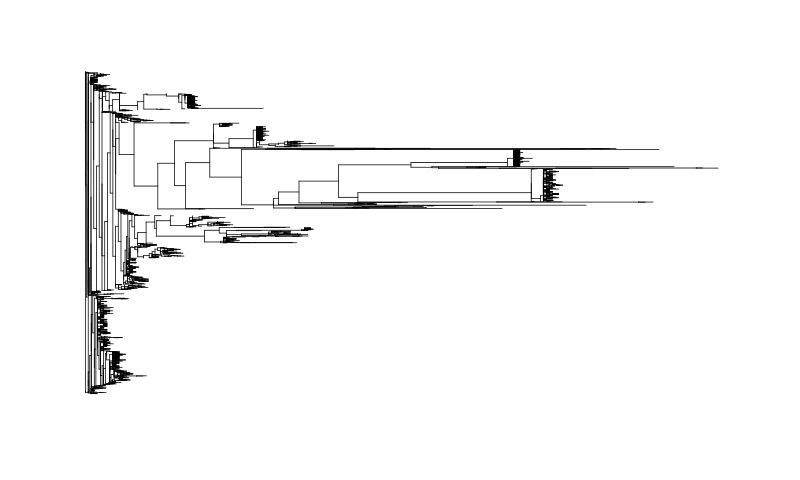

In [113]:
%%R -w 800 -h 480 -u px
library(ape)

otu_tree <- read.tree("RAxML_bestTree.fishpoo_ssu.raxml")
plot(otu_tree, show.tip.label=FALSE)

In [11]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

ape = importr('ape')
phytools = importr('phytools')
adephylo = importr('adephylo')
phylobase = importr('phylobase')

# read in the big fish tree
rabosky = ape.read_tree( "host_tree/raboskytree/Rabosky_et_al_timetree.tre" )

# read microbe tree
rep_set = ape.read_tree( "fishpoo_open97/rep_set.tre" )

# compute the list of taxa to drop from the big fish tree
myfishnames  = set(open("host_tree/raboskytree/fish_names.txt").read().split())
allfishnames = set(rabosky.rx('tip.label')[0])
dropnames    = allfishnames.difference(myfishnames)

# drop the fish I don't need
rabosky_trimmed = ape.drop_tip( rabosky, ro.vectors.StrVector( list(dropnames) ) )

# not all of my fish are in the big tree, so we're going to use
# their sister taxa as stand-ins
rabosky_trimmed[2][ rabosky_trimmed[2].index('Neolamprologus_cylindricus')   ] = "Neolamprologus_buescheri"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Cyprichromis_jumbo')           ] = "Cyprichromis_coloratus"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Baileychromis_centropomoides') ] = "Reganochromis_calliurus"
rabosky_trimmed[2][ rabosky_trimmed[2].index('Limnochromis_abeelei')         ] = "Trematochromis_benthicola"

In [12]:
def bloomberg_k( host_tree, trait_table ) :
    ''' Bloomberg's K'''
    phytools.phylosig( host_tree, trait_table, method='K' )[0]

def abouheif_cmean( host_tree, trait_table ) :
    '''Abouheif's Cmean'''
    return adephylo.abouheif_moran( phylobase.phylo4d( host_tree, trait_table ), method="oriAbouheif" )[1][0]

def pagel_lambda( host_tree, trait_table ) :
    '''Pagel's lambda'''
    return map( lambda x : x[0], phytools.phylosig( host_tree, tt, method='lambda' ) )[0]

def moran_i( host_tree, trait_table ) :
    '''Moran's I'''
    return adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tt ), method="Abouheif" )[1][0]
    
tt = ro.vectors.FloatVector( otu_table['HAPLMIC2_37779'] )
tt.names = map( lambda x : x.replace(' ','_'),  otu_table.index )

print 'K : ', bloomberg_k( rabosky_trimmed, tt)
print 'lambda : ', pagel_lambda( rabosky_trimmed, tt ) 
print 'Cmean : ', abouheif_cmean( rabosky_trimmed, tt )
print 'I : ', moran_i( rabosky_trimmed, tt )

K :  None
lambda :  7.96099561485e-05
Cmean :  -0.0976207387486
I :  -0.241811915197


In [13]:
import ProgressBar

Cmean = []
p = ProgressBar.ProgressBar(len(non_rare_otus))
for n,otu in enumerate(non_rare_otus) :
    p.animate(n+1)
    tt = ro.vectors.FloatVector( otu_table[otu] )
    tt.names = map( lambda x : x.replace(' ','_'),  otu_table.index )
    Cmean.append( abouheif_cmean( rabosky_trimmed, tt ) )

[****************100%******************]  1844 of 1844 complete


In [ ]:
ttt = ro.vectors.FloatVector( Cmean )
ttt.names = non_rare_otus

# load the tree and convert it into a dichotomous phylogeny
otu_tree = ape.multi2di( ape.read_tree("RAxML_bestTree.fishpoo_ssu.raxml"), random = True )

In [143]:
abouheif_cmean( otu_tree, ttt )
#pagel_lambda( ape.di2multi(otu_tree), ttt )

0.17289150418669255

In [243]:
otu_table[non_rare_otus].to_csv('fishpoo_nonrare_otus.csv')

# For some reason, the RAxML tree dropped a few tips, so
# I guess we'll drop them from the trait table for now.
import dendropy

microbe_tree = dendropy.Tree.get( path='RAxML_bestTree.fishpoo_ssu.raxml', schema='newick')
tips = set(map( lambda x: x.taxon.label.replace(' ','_'), microbe_tree.leaf_nodes() )) & set(non_rare_otus)

#Cmean_df = pd.DataFrame()
#Cmean_df['Cmean'] = Cmean
#Cmean_df.index = non_rare_otus
#Cmean_df.ix[list(tips)].to_csv('fishpoo_nonrare_phylosigs.csv')
with open( 'fishpoo_nonrare_phylosigs.csv', 'w') as f :
    f.write('OTU,Cmean\n')
    for tip in tips :
        f.write( ','.join( ( tip, str(Cmean[ non_rare_otus.index(tip) ]) ) ) + '\n' )

In [252]:
%%R -w 800 -h 480 -u px

library(ape)

# This tree comes from here : http://datadryad.org/resource/doi:10.5061/dryad.j4802

otu_tree <- read.tree("RAxML_bestTree.fishpoo_ssu.raxml")

# stochastic character mapping

library("phytools")
non_rare_phylosigs <- read.csv("fishpoo_nonrare_phylosigs.csv", sep=",", row.names=1)

# use make.simmap() for categorical data : http://www.inside-r.org/packages/cran/phytools/docs/make.simmap
# use contMap() for continious data : http://www.inside-r.org/node/166056

# we need this function to change the color mapping...
# code is from here : http://blog.phytools.org/2014/12/inverting-color-map-on-object-of-class.html
setMap<-function(x,...){
    if(hasArg(invert)) invert<-list(...)$invert
    else invert<-FALSE
    n<-length(x$cols)
    if(invert) x$cols<-setNames(rev(x$cols),names(x$cols))
    else x$cols[1:n]<-colorRampPalette(...)(n)
    x
}

obj <- contMap( otu_tree, as.matrix(non_rare_phylosigs)[,'Cmean'], plot=FALSE )
plot(setMap(obj,invert=TRUE))


Error in tree$maps[[i]] <- XX[, 2] - XX[, 1] : 
  more elements supplied than there are to replace


/usr/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in tree$maps[[i]] <- XX[, 2] - XX[, 1] : 
  more elements supplied than there are to replace

  res = super(Function, self).__call__(*new_args, **new_kwargs)


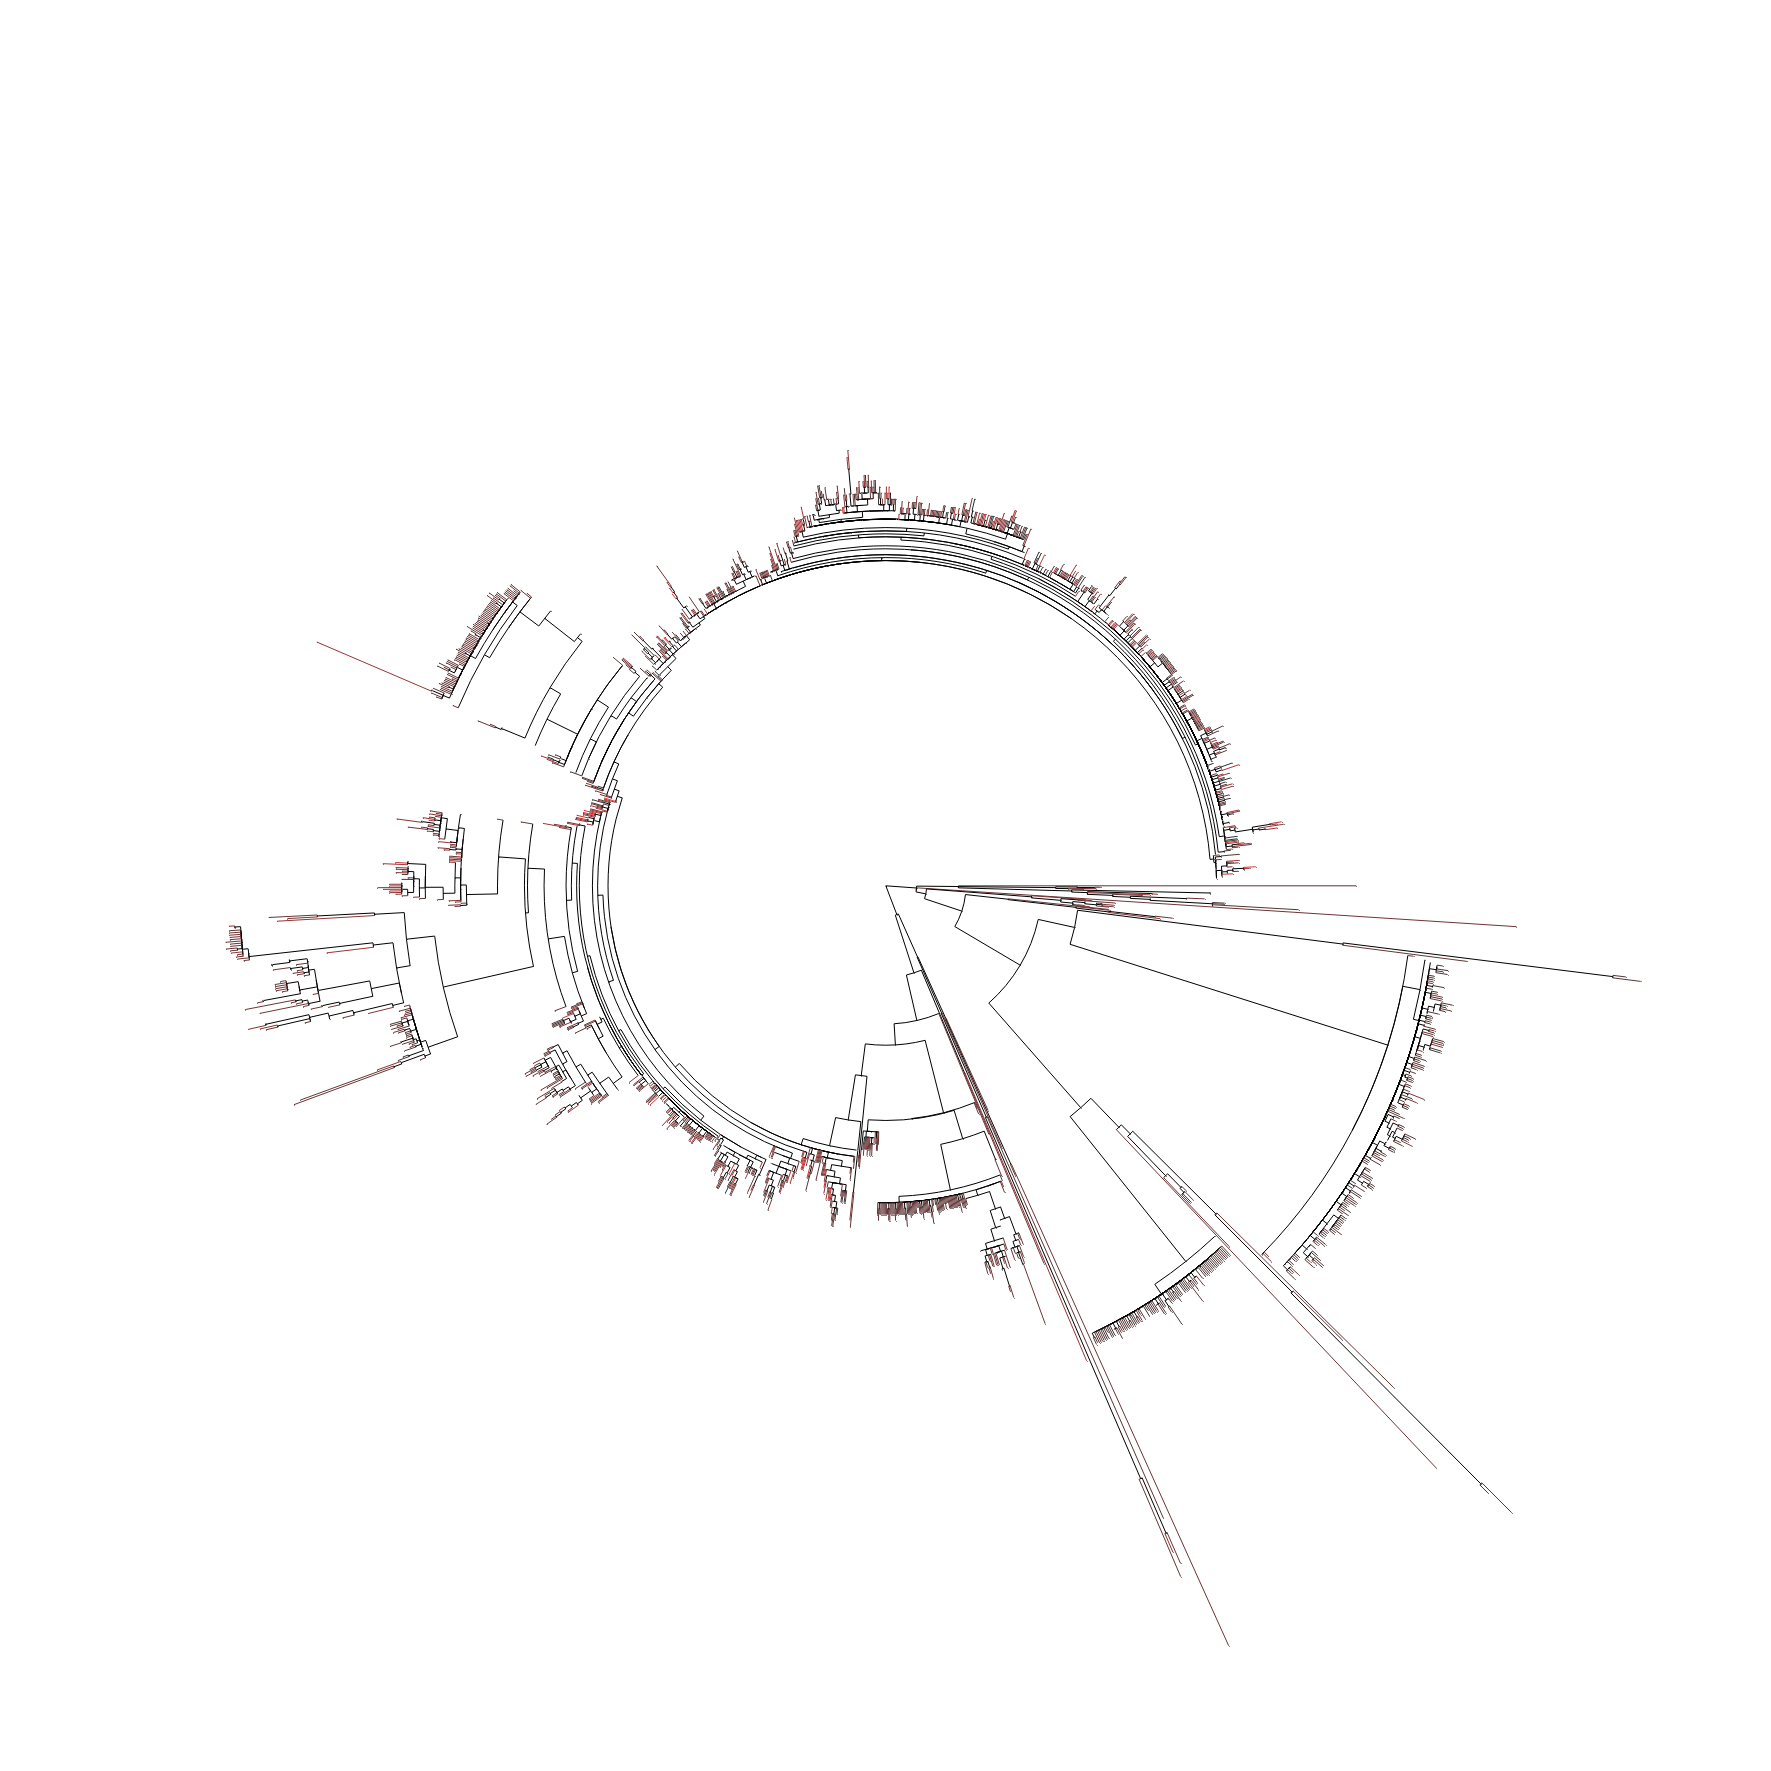

In [45]:
from ete2 import Tree, TreeStyle, NodeStyle
from numpy import linspace

ts = TreeStyle()
#ts.mode = 'r'
ts.mode = 'c'
ts.show_leaf_name = False
ts.branch_vertical_margin = 30
ts.scale = 1000000

t = Tree('RAxML_bestTree.fishpoo_ssu.raxml')
t.set_outgroup( t.get_midpoint_outgroup() ) # balance the unrooted tree

Cmean_dict = dict( zip( non_rare_otus, Cmean ) )

colors = linspace( min(Cmean), max(Cmean), 256 )

for node in t.traverse() :
    if node.is_leaf() :
        nstyle = NodeStyle()
        #nstyle["size"] = 5
        for n in range(256) :
            if colors[n] > Cmean_dict[node.name] : break
        c = '#' + str(hex(n)).split('x')[1] + '3333'
        nstyle["fgcolor"] = c
        #nstyle["bgcolor"] = c
        nstyle["hz_line_color"] = c
        node.set_style(nstyle)
    else :
        nstyle = NodeStyle()
        nstyle["hz_line_color"] = '999999'
        node.set_style(nstyle)
        
t.render("%%inline", w=500, units="mm", tree_style=ts)
#t.render("phylosig-of-phylosig.svg", w=200, units="mm", tree_style=ts)

'32'